# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

Using TensorFlow backend.


In [22]:
DATA_PATH = Path('../../QCHS-2018/Data/')

## Options

In [24]:
with open(DATA_PATH/'features.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [25]:
n_models = 10
patience = 2
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 31 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_py', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [27]:
with open(DATA_PATH/'inputPipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [28]:
train_fy = RotationReflectionFold(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"),
                                 input_pipe=input_pipe, rot_mult=16)

In [32]:
train_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'train.hdf5', "r+"),
                                 input_pipe=input_pipe, rot_mult=16)

## Determine LR

2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.108621). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.110375). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106483). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.106629). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in


______________________________________
Training finished
Cross-validation took 28.094s 


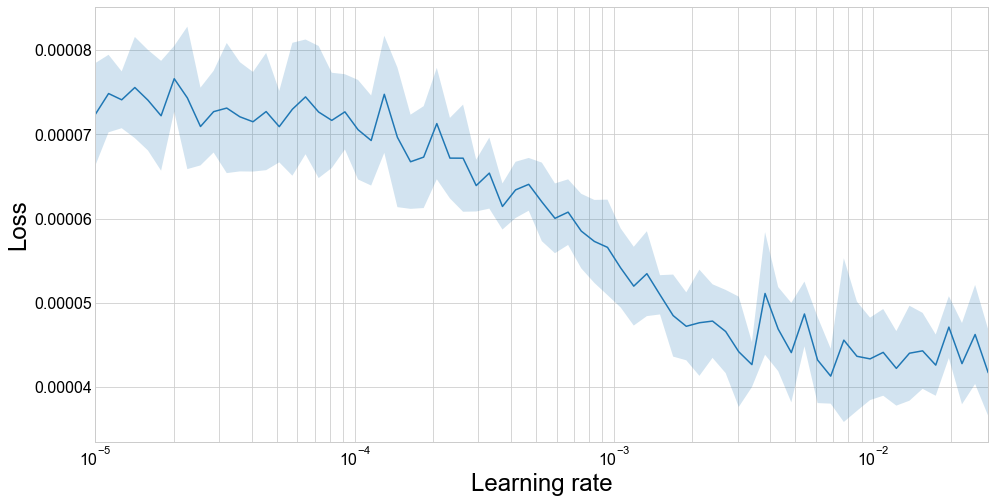

______________________________________



In [33]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [34]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {'CosAnnealLR':{'cycle_mult':2, 'reverse':False, 'redux_decay':True}}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
Using cosine LR annealing
2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.697735). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.349302). Check your callbacks.
  % delta_t_median)


1 New best found: 3.976288602571003e-05
2 New best found: 3.682332345924806e-05
3 New best found: 3.630991066311253e-05
4 New best found: 3.589396785682766e-05
5 New best found: 3.5694191642687655e-05
6 New best found: 3.497586198936915e-05
7 New best found: 3.4803550454671494e-05
10 New best found: 3.479528449533973e-05
11 New best found: 3.472851570259081e-05
12 New best found: 3.419297147775069e-05
13 New best found: 3.3939967707556206e-05
14 New best found: 3.3787883130571575e-05
15 New best found: 3.3770629354694394e-05
23 New best found: 3.34753571631154e-05
24 New best found: 3.340891668121913e-05
26 New best found: 3.3293186503578905e-05
27 New best found: 3.3225075368682156e-05
28 New best found: 3.3125758607639e-05
29 New best found: 3.310451227516751e-05
30 New best found: 3.308682151400717e-05
31 New best found: 3.3076576846360697e-05
47 New best found: 3.3023478533141314e-05
48 New best found: 3.292423410457559e-05
51 New best found: 3.2790794293396175e-05
54 New best foun

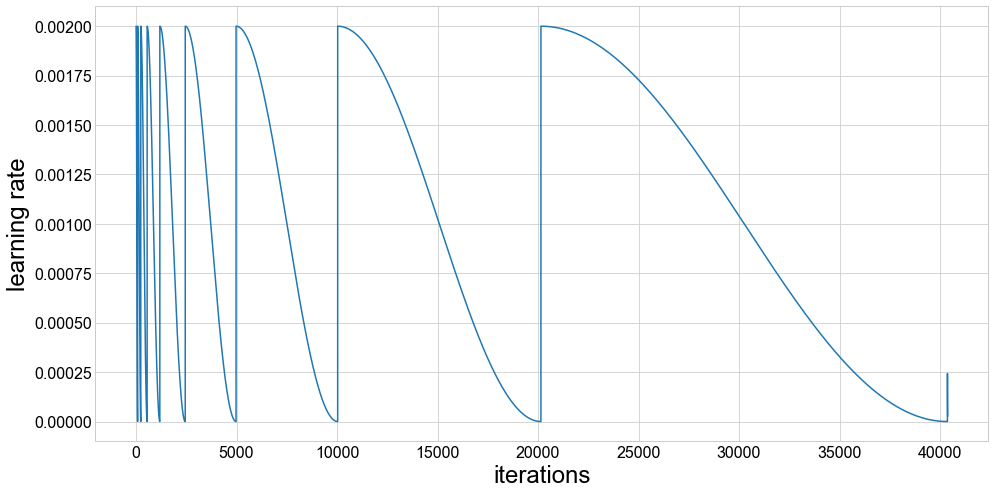

Fold took 488.450s

Training model 2 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.677475). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.339193). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9470084676577246e-05
2 New best found: 3.668707298929803e-05
3 New best found: 3.583063790720189e-05
5 New best found: 3.51982002321165e-05
6 New best found: 3.4246389976760835e-05
7 New best found: 3.415368005080381e-05
9 New best found: 3.391343408584362e-05
10 New best found: 3.3701991211273706e-05
11 New best found: 3.3609587598766664e-05
12 New best found: 3.3529762274702077e-05
13 New best found: 3.327936114947079e-05
14 New best found: 3.306088838726282e-05
15 New best found: 3.302559856238076e-05
21 New best found: 3.294750006607501e-05
22 New best found: 3.2937610025692266e-05
23 New best found: 3.293293686438119e-05
25 New best found: 3.28296698135091e-05
26 New best found: 3.252724183403188e-05
27 New best found: 3.236976152402349e-05
29 New best found: 3.2340244005899875e-05
30 New best found: 3.2330186165927445e-05
31 New best found: 3.232663243106799e-05
49 New best found: 3.214627708512125e-05
52 New best found: 3.210575636767316e-05
53 New best found

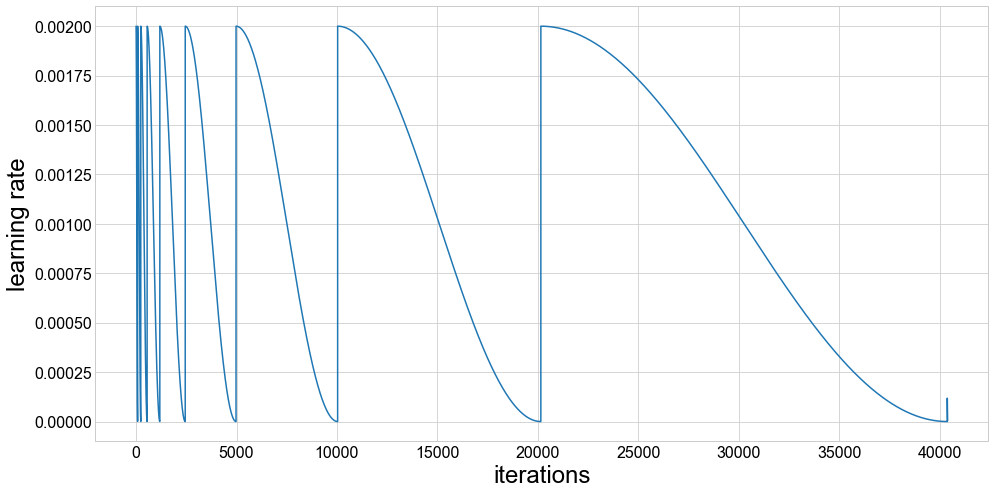

Fold took 493.570s

Training model 3 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.699530). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.350284). Check your callbacks.
  % delta_t_median)


1 New best found: 3.941683106354119e-05
2 New best found: 3.615556619304809e-05
3 New best found: 3.575591609754504e-05
5 New best found: 3.485563402511654e-05
6 New best found: 3.44435102605913e-05
7 New best found: 3.424246741294937e-05
10 New best found: 3.404170604128482e-05
12 New best found: 3.360634691057634e-05
13 New best found: 3.341011085928755e-05
14 New best found: 3.329506006673724e-05
15 New best found: 3.3282014308026536e-05
22 New best found: 3.3251893677197874e-05
24 New best found: 3.304459955417053e-05
26 New best found: 3.2990984371642596e-05
27 New best found: 3.2852507097118524e-05
28 New best found: 3.2851604273050645e-05
29 New best found: 3.278637175305448e-05
30 New best found: 3.27683552445483e-05
47 New best found: 3.2688972413384084e-05
51 New best found: 3.243347021185334e-05
56 New best found: 3.243050453836147e-05
57 New best found: 3.241790268905539e-05
58 New best found: 3.238590548752838e-05
61 New best found: 3.238224867997328e-05
62 New best found:

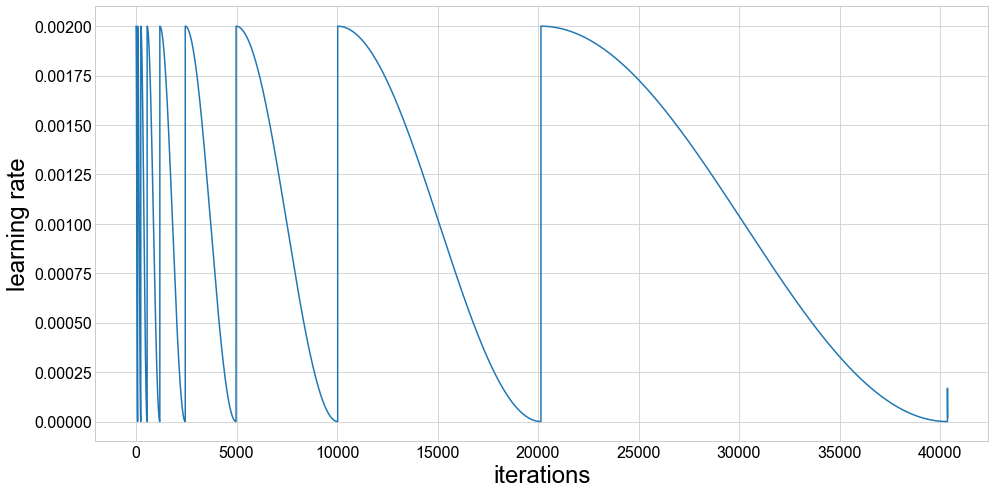

Fold took 493.301s

Training model 4 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.714430). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.357701). Check your callbacks.
  % delta_t_median)


1 New best found: 4.074507080782167e-05
2 New best found: 3.7417969795245775e-05
3 New best found: 3.654776496862506e-05
4 New best found: 3.630951668354976e-05
5 New best found: 3.527745326128111e-05
6 New best found: 3.483780113380966e-05
7 New best found: 3.477557707007469e-05
10 New best found: 3.425345206673405e-05
12 New best found: 3.409938158841016e-05
13 New best found: 3.375192045700725e-05
14 New best found: 3.3602891836212655e-05
15 New best found: 3.357475570811861e-05
21 New best found: 3.3467407172763066e-05
22 New best found: 3.340124703006458e-05
25 New best found: 3.3262390951113884e-05
27 New best found: 3.299589040721783e-05
28 New best found: 3.298420352827235e-05
29 New best found: 3.288442201630367e-05
30 New best found: 3.2880588100440244e-05
31 New best found: 3.28742640784007e-05
52 New best found: 3.281428471480472e-05
53 New best found: 3.270576034582498e-05
54 New best found: 3.2582825131025735e-05
55 New best found: 3.2488401240831635e-05
59 New best found

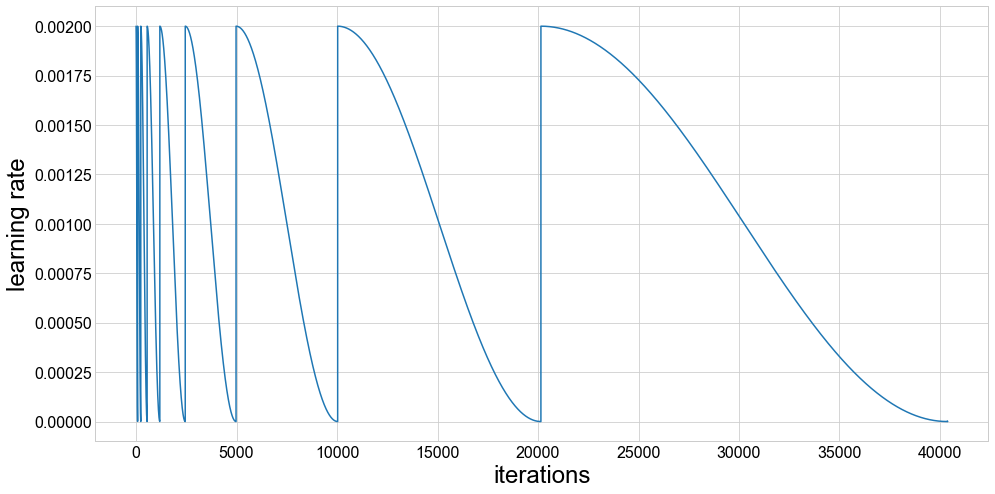

Fold took 499.747s

Training model 5 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.756936). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.379060). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9196086241281595e-05
2 New best found: 3.6201117372547744e-05
3 New best found: 3.554358615074307e-05
4 New best found: 3.539756500249496e-05
5 New best found: 3.480814270442352e-05
6 New best found: 3.404171816800954e-05
7 New best found: 3.392872130061733e-05
10 New best found: 3.372511330235284e-05
11 New best found: 3.355788344342727e-05
12 New best found: 3.305768191785319e-05
13 New best found: 3.294275389926043e-05
14 New best found: 3.28383172120084e-05
15 New best found: 3.279531154257711e-05
23 New best found: 3.262403843618813e-05
25 New best found: 3.236248753164546e-05
28 New best found: 3.2253087492426855e-05
29 New best found: 3.222957153629977e-05
30 New best found: 3.218191308551468e-05
48 New best found: 3.215412119534449e-05
50 New best found: 3.196117939223768e-05
52 New best found: 3.190610035671852e-05
53 New best found: 3.182122890138999e-05
57 New best found: 3.1762513025751104e-05
59 New best found: 3.1756418511213266e-05
60 New best found: 

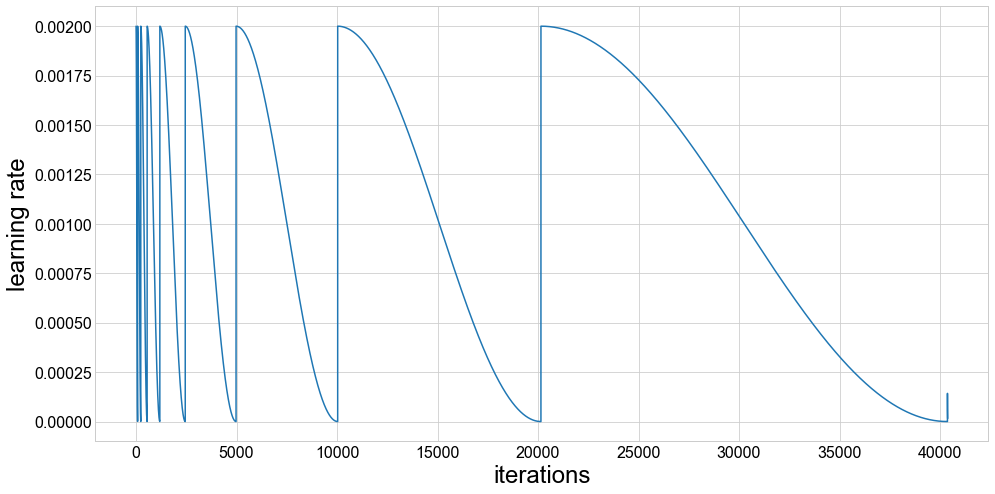

Fold took 507.947s

Training model 6 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.749909). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.375404). Check your callbacks.
  % delta_t_median)


1 New best found: 3.916035460861167e-05
2 New best found: 3.77983892467455e-05
3 New best found: 3.568127654434648e-05
5 New best found: 3.462836955004604e-05
6 New best found: 3.4280002090963535e-05
7 New best found: 3.413138791802339e-05
10 New best found: 3.3639877200766934e-05
11 New best found: 3.3386073500878413e-05
12 New best found: 3.318724707933143e-05
13 New best found: 3.309745996230049e-05
14 New best found: 3.288297320905258e-05
15 New best found: 3.286922120532836e-05
23 New best found: 3.2600243119668446e-05
25 New best found: 3.251736790989526e-05
26 New best found: 3.249755747601739e-05
27 New best found: 3.234231318274396e-05
28 New best found: 3.227547420829069e-05
30 New best found: 3.2205420481477633e-05
50 New best found: 3.207786416678573e-05
53 New best found: 3.2033621150185354e-05
54 New best found: 3.200004702666774e-05
57 New best found: 3.1895430888107515e-05
58 New best found: 3.188901707908372e-05
59 New best found: 3.184738700219896e-05
100 New best fou

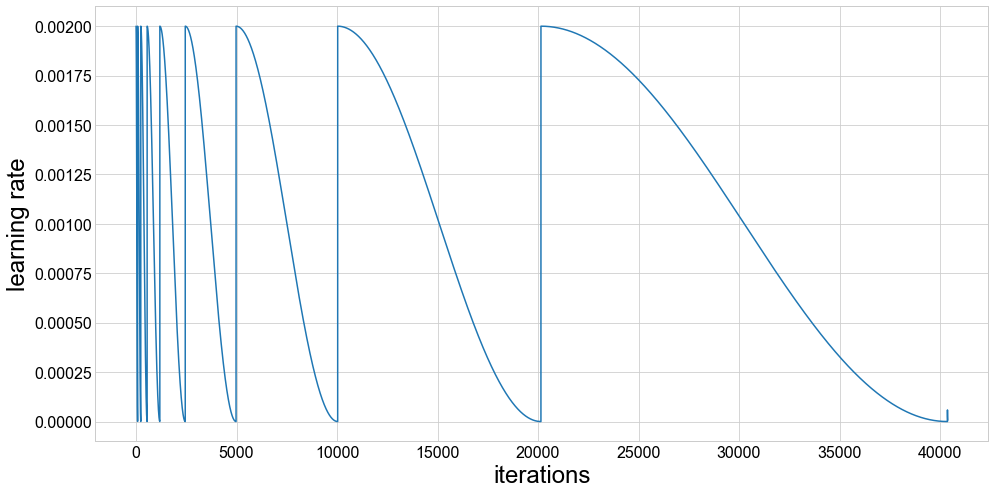

Fold took 512.845s

Training model 7 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.748360). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.374679). Check your callbacks.
  % delta_t_median)


1 New best found: 3.801198430624074e-05
2 New best found: 3.567564529865493e-05
3 New best found: 3.498254643648915e-05
4 New best found: 3.474256259954441e-05
5 New best found: 3.3996285114674957e-05
6 New best found: 3.376754840185825e-05
7 New best found: 3.35418631241272e-05
10 New best found: 3.330630597269213e-05
11 New best found: 3.313422806786375e-05
12 New best found: 3.2898580080275876e-05
13 New best found: 3.276223758772723e-05
14 New best found: 3.270560924224104e-05
15 New best found: 3.2668684777864776e-05
23 New best found: 3.25185364870783e-05
24 New best found: 3.24806689065717e-05
25 New best found: 3.237322763065056e-05
27 New best found: 3.224474768512598e-05
28 New best found: 3.217983685579825e-05
29 New best found: 3.2127915091236035e-05
30 New best found: 3.209760238598632e-05
47 New best found: 3.1991531754367575e-05
48 New best found: 3.195238805727949e-05
50 New best found: 3.191669742114142e-05
53 New best found: 3.1784116970212046e-05
55 New best found: 3

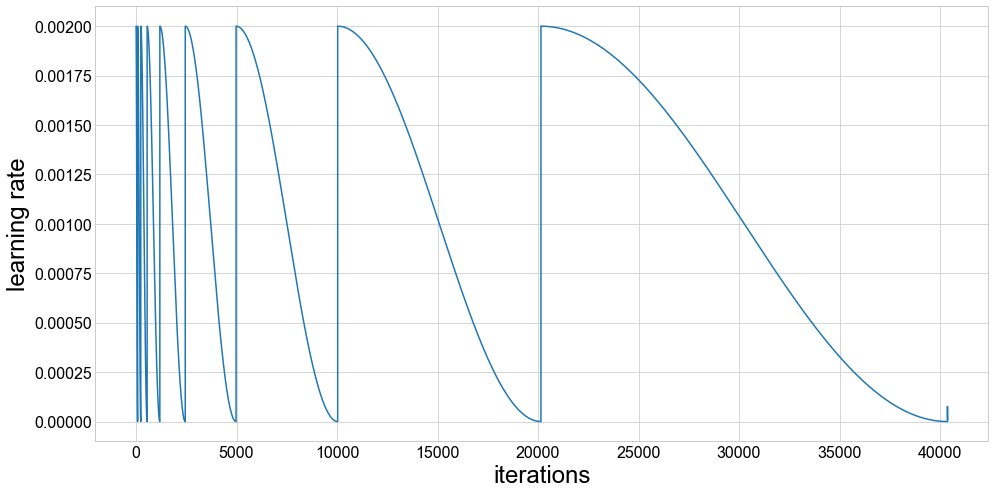

Fold took 520.256s

Training model 8 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.786261). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.393599). Check your callbacks.
  % delta_t_median)


1 New best found: 3.973460462438241e-05
2 New best found: 3.6580085706263123e-05
3 New best found: 3.5814662531988635e-05
4 New best found: 3.575878569375461e-05
5 New best found: 3.52342317139785e-05
6 New best found: 3.453816520224072e-05
7 New best found: 3.4348575058614846e-05
11 New best found: 3.404018852429973e-05
12 New best found: 3.37043102070756e-05
13 New best found: 3.359308727740765e-05
14 New best found: 3.35745067356835e-05
15 New best found: 3.351778089335446e-05
20 New best found: 3.3300030172830715e-05
24 New best found: 3.326271552634774e-05
25 New best found: 3.311903926973072e-05
26 New best found: 3.296677463941007e-05
28 New best found: 3.287589492368816e-05
29 New best found: 3.281032733086301e-05
30 New best found: 3.280349370210193e-05
31 New best found: 3.2798126653034353e-05
43 New best found: 3.277500509499088e-05
47 New best found: 3.2689675056182406e-05
48 New best found: 3.2645228474589166e-05
52 New best found: 3.2553663937416145e-05
55 New best found:

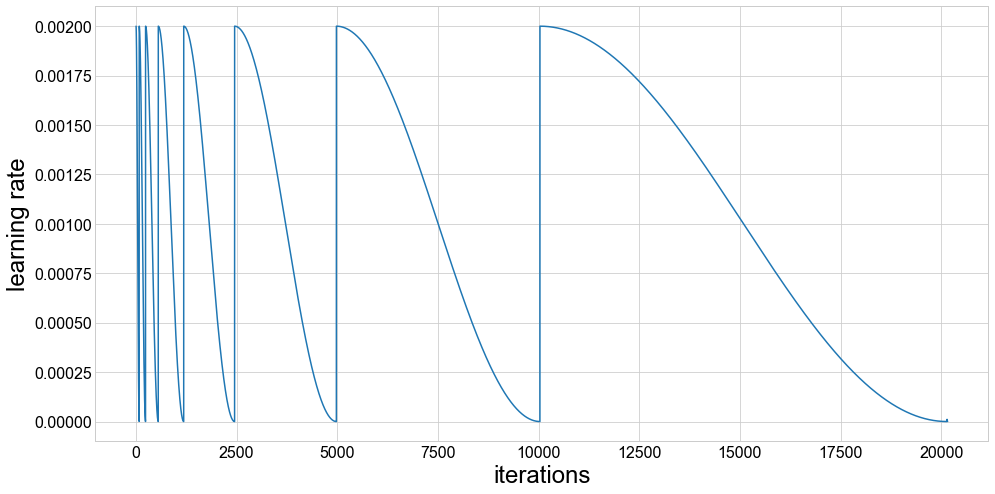

Fold took 278.862s

Training model 9 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.791730). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.396336). Check your callbacks.
  % delta_t_median)


1 New best found: 3.992088820190334e-05
2 New best found: 3.702094505458984e-05
3 New best found: 3.6550254877885725e-05
5 New best found: 3.559042678462389e-05
6 New best found: 3.527669881180069e-05
7 New best found: 3.5109544340423246e-05
9 New best found: 3.48585112996489e-05
10 New best found: 3.4781297119416735e-05
12 New best found: 3.435139176447935e-05
13 New best found: 3.384061960481388e-05
14 New best found: 3.380517769073549e-05
15 New best found: 3.376218360105888e-05
22 New best found: 3.352496513230034e-05
24 New best found: 3.345822212151085e-05
25 New best found: 3.336065154782259e-05
26 New best found: 3.312969526710598e-05
27 New best found: 3.30467866771056e-05
28 New best found: 3.300101917476746e-05
29 New best found: 3.2977200918406254e-05
30 New best found: 3.295696440361908e-05
31 New best found: 3.295058786409293e-05
46 New best found: 3.290448991161901e-05
47 New best found: 3.2838327702536195e-05
51 New best found: 3.270680236489659e-05
54 New best found: 3

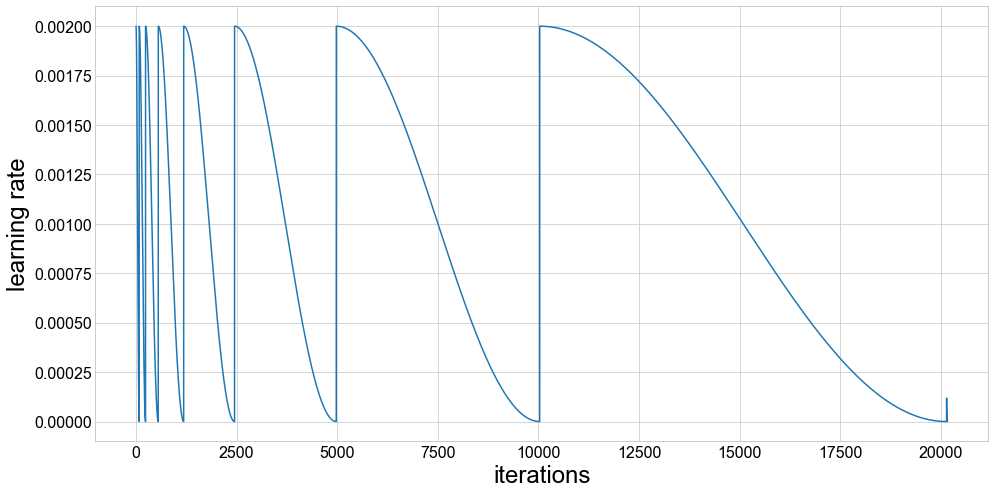

Fold took 293.282s

Training model 10 / 10
Using cosine LR annealing


/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.816196). Check your callbacks.
  % delta_t_median)
/Users/giles/anaconda3/lib/python3.6/site-packages/keras/callbacks.py:122: UserWarning: Method on_batch_end() is slow compared to the batch update (0.408647). Check your callbacks.
  % delta_t_median)


1 New best found: 3.9275670641075245e-05
2 New best found: 3.600776580236971e-05
3 New best found: 3.5682022728820225e-05
5 New best found: 3.5019225578917414e-05
6 New best found: 3.426552445129955e-05
7 New best found: 3.41351223698627e-05
11 New best found: 3.401821567009771e-05
13 New best found: 3.350981547755685e-05
14 New best found: 3.34403558911666e-05
15 New best found: 3.343047603436574e-05
21 New best found: 3.338555857483077e-05
25 New best found: 3.32002473507951e-05
26 New best found: 3.30175192608376e-05
27 New best found: 3.2940920194121855e-05
28 New best found: 3.286788479929391e-05
29 New best found: 3.2784126117585826e-05
31 New best found: 3.278307654814887e-05
47 New best found: 3.261911165808828e-05
50 New best found: 3.2612240838674814e-05
51 New best found: 3.258106232893918e-05
52 New best found: 3.251048303446334e-05
54 New best found: 3.2400491412388505e-05
55 New best found: 3.236777780432891e-05
56 New best found: 3.232386678424492e-05
58 New best found: 

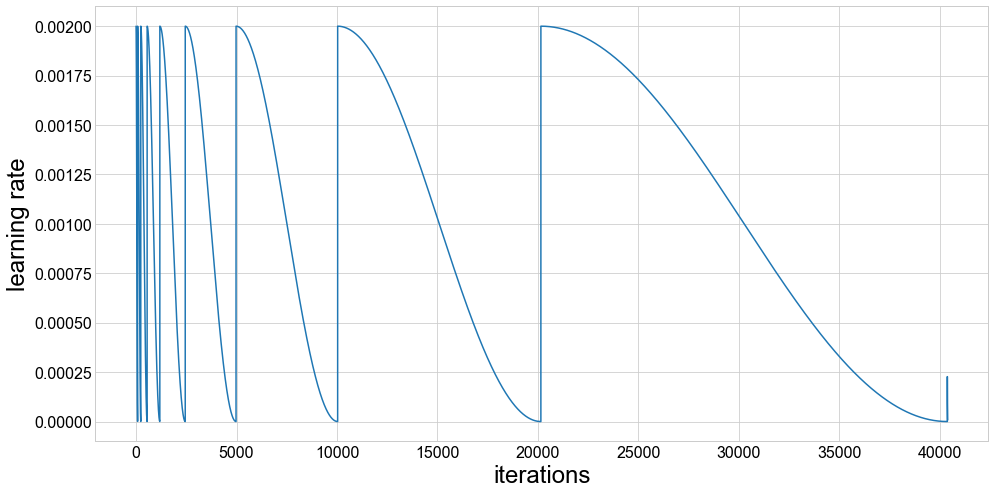

Fold took 579.346s


______________________________________
Training finished
Cross-validation took 4677.712s 


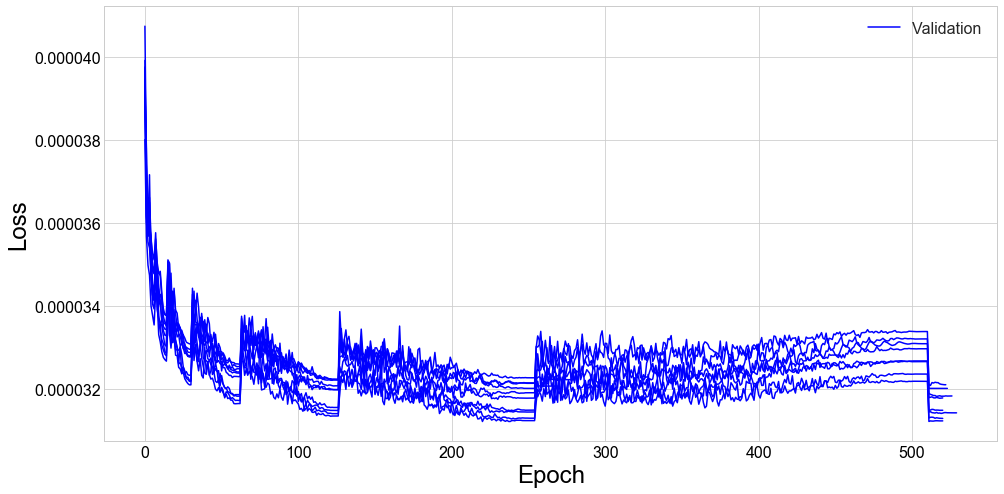

Mean loss = 3.17e-05 +- 1e-07
Mean wAUC = 0.0633 +- 0.0004
Mean AUC = 0.0983 +- 0.0004
Mean AMS = 3.96 +- 0.06
Mean cut = 0.967 +- 0.004
______________________________________



<Figure size 432x288 with 0 Axes>

In [36]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

The impact of data augmentation is pretty clear. Comparing the training here to that of the the CRL Swish model without augmentation we can see that we effectively gain another LR cycles worth of training epochs before we start overfitting, which allows the networks to reach much lower looses (3.18e-5 c.f. 3.23e-5) and a higher AMSs (3.98 c.f. 3.71)

## Construct ensemble

In [37]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [41]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 6 with loss = 3.1212553172411135e-05
Model 1 is 4 with loss = 3.1272695296502205e-05
Model 2 is 1 with loss = 3.1407773071259724e-05
Model 3 is 5 with loss = 3.147264777071541e-05
Model 4 is 2 with loss = 3.17476084445297e-05
Model 5 is 9 with loss = 3.1817523321593746e-05
Model 6 is 3 with loss = 3.201115552336507e-05
Model 7 is 7 with loss = 3.2066708306895085e-05
Model 8 is 0 with loss = 3.20824644586537e-05
Model 9 is 8 with loss = 3.22203218153157e-05


## Response on validation data without TTA

In [42]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [43]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0024554180849998375s per sample

Predicting fold 2 out of 10
Prediction took 0.00036566371899971275s per sample

Predicting fold 3 out of 10
Prediction took 0.0003668667739999364s per sample

Predicting fold 4 out of 10
Prediction took 0.00036466117639938605s per sample

Predicting fold 5 out of 10
Prediction took 0.00036270965820003767s per sample

Predicting fold 6 out of 10
Prediction took 0.0003719014968010015s per sample

Predicting fold 7 out of 10
Prediction took 0.0003712444780001533s per sample

Predicting fold 8 out of 10
Prediction took 0.0003673036406005849s per sample

Predicting fold 9 out of 10
Prediction took 0.00036793346220074456s per sample

Predicting fold 10 out of 10
Prediction took 0.00036334201919962654s per sample



In [44]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9038349283978752, weighted 0.9362912730872188


In [48]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(4.003634312874257, 0.96287787)

In [50]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.961+-0.008
Exact mean cut 0.9611195212928578, corresponds to calc_ams of 3.996349323181344
CPU times: user 3.38 s, sys: 5.76 s, total: 9.15 s
Wall time: 1min 30s


(4.0, 0.961)

With test-time augmentation we improve on 4_Model_Swish_Cyclical-LR in all metrics on validation data: overall AMS 3.77->3.90, AMS corresponding to mean cut 3.72->3.89.

## Response on validation data with TTA

In [51]:
val_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'val.hdf5', "r+"), input_pipe=input_pipe,
                                  rotate = True, reflect = True, rot_mult=8)

In [52]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.012234361639201233s per sample

Predicting fold 2 out of 10
Prediction took 0.011975128332799068s per sample

Predicting fold 3 out of 10
Prediction took 0.011874590497399914s per sample

Predicting fold 4 out of 10
Prediction took 0.011945793469999626s per sample

Predicting fold 5 out of 10
Prediction took 0.012353904423800122s per sample

Predicting fold 6 out of 10
Prediction took 0.012879486162800458s per sample

Predicting fold 7 out of 10
Prediction took 0.012975901530600095s per sample

Predicting fold 8 out of 10
Prediction took 0.012874427950599057s per sample

Predicting fold 9 out of 10
Prediction took 0.011881580304598901s per sample

Predicting fold 10 out of 10
Prediction took 0.012057686634600395s per sample



In [53]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9038664775388925, weighted 0.9363122867858962


In [54]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.978068120608682, 0.9596411)

In [55]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.962+-0.009
Exact mean cut 0.961930352030322, corresponds to calc_ams of 3.946954153522163
CPU times: user 3.41 s, sys: 5.86 s, total: 9.27 s
Wall time: 1min 30s


(4.0, 0.962)

Adding test-time augmentation provides further benefits: overall AMS 3.90->3.97, AMS corresponding to mean cut 3.89->3.91.

# Test scoring - Without TTA

In [64]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [65]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00040122347760003654s per sample

Predicting fold 2 out of 10
Prediction took 0.00037969114465456435s per sample

Predicting fold 3 out of 10
Prediction took 0.00038847910901822615s per sample

Predicting fold 4 out of 10
Prediction took 0.0003758922264363553s per sample

Predicting fold 5 out of 10
Prediction took 0.0003577624636546137s per sample

Predicting fold 6 out of 10
Prediction took 0.00035725513212726747s per sample

Predicting fold 7 out of 10
Prediction took 0.0003604796926363964s per sample

Predicting fold 8 out of 10
Prediction took 0.00036280321489082944s per sample

Predicting fold 9 out of 10
Prediction took 0.0003687603450363068s per sample

Predicting fold 10 out of 10
Prediction took 0.000365420205290932s per sample

CPU times: user 3min 38s, sys: 12.5 s, total: 3min 50s
Wall time: 3min 24s


In [66]:
score_test_data(test_fy.source, 0.9611195212928578)

Public:Private AMS: 3.6975080502854594 : 3.7934559913229284


(3.6975080502854594, 3.7934559913229284)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Test scoring - With TTA

In [68]:
test_fy = HEPAugFoldYielder(train_feats, h5py.File(DATA_PATH/'testing.hdf5', "r+"), input_pipe=input_pipe,
                                   rotate = True, reflect = True, rot_mult=8)

In [69]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.011856041907254521s per sample

Predicting fold 2 out of 10
Prediction took 0.011448075622836371s per sample

Predicting fold 3 out of 10
Prediction took 0.011448498322836398s per sample

Predicting fold 4 out of 10
Prediction took 0.01145552496870911s per sample

Predicting fold 5 out of 10
Prediction took 0.01143524411796362s per sample

Predicting fold 6 out of 10
Prediction took 0.011450975338127384s per sample

Predicting fold 7 out of 10
Prediction took 0.011455480268054551s per sample

Predicting fold 8 out of 10
Prediction took 0.011449146213254558s per sample

Predicting fold 9 out of 10
Prediction took 0.011453849896763726s per sample

Predicting fold 10 out of 10
Prediction took 0.011467270444654488s per sample

CPU times: user 1h 52min 5s, sys: 6min 26s, total: 1h 58min 32s
Wall time: 1h 45min 20s


In [70]:
score_test_data(test_fy.source, 0.961930352030322)

Public:Private AMS: 3.6715485366505813 : 3.7993155098278657


(3.6715485366505813, 3.7993155098278657)

In [85]:
score_test_data(test_fy.source, 0.953)

Public:Private AMS: 3.8377718138438524 : 3.8295079944660015


(3.8377718138438524, 3.8295079944660015)

Using the cuts we optimised by bootstrapping the validation data, we end up with a private score which would have beaten the winning entry (3.817 c.f. 3.806). It would be nice if the public score were higher, though.

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)